# Peramalan Bahan Bakar Unit Excavator HSR


## Latar Belakang
Peramalan bahan bakar pada unit excavator sangat penting karena bahan bakar merupakan salah satu komponen penting dalam operasional unit excavator. Dengan melakukan peramalan bahan bakar, Anda dapat memperkirakan berapa banyak bahan bakar yang dibutuhkan untuk menjalankan unit excavator pada suatu waktu tertentu.

Dalam bisnis konstruksi atau pertambangan, bahan bakar biasanya menjadi salah satu biaya terbesar. Dengan melakukan peramalan bahan bakar, Anda dapat memperkirakan biaya operasional yang akan dikeluarkan untuk mengoperasikan unit excavator dalam periode tertentu. Hal ini dapat membantu Anda untuk mengoptimalkan penggunaan bahan bakar dan mengurangi biaya operasional secara keseluruhan.

Selain itu, peramalan bahan bakar juga dapat membantu dalam perencanaan pemeliharaan dan penggantian suku cadang pada unit excavator. Dengan mengetahui jumlah bahan bakar yang digunakan oleh unit excavator dalam periode tertentu, Anda dapat memperkirakan kapan waktu yang tepat untuk melakukan perawatan dan penggantian suku cadang pada unit excavator agar tidak mengganggu produktivitas kerja.

Dengan demikian, peramalan bahan bakar merupakan hal yang sangat penting dalam pengelolaan unit excavator, karena dapat membantu Anda mengoptimalkan penggunaan bahan bakar, mengurangi biaya operasional, dan meningkatkan produktivitas kerja secara keseluruhan.

## Dataset 
Data yang digunakan dalam peramalan ini menggunakan akumulasi data pengisian dari masing-masing unit excavator 



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from autots import AutoTS
from autots.models.model_list import model_lists

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

# Data Preparation
Pada data preparation terdapat beberapa tahap yaitu:
- import dataset
- memilih/menghapus kolom yang tidak digunakan
- melakukan transformasi data

In [2]:
## Lokasi dataset
path = '../Model Forecasting/Data_FCFR Final.xlsx'

In [3]:
## import dataset code unit EX41
ex41 = pd.read_excel(path, sheet_name=0)
ex42 = pd.read_excel(path, sheet_name=1)
ex43 = pd.read_excel(path, sheet_name=2)
ex44 = pd.read_excel(path, sheet_name=3)

In [4]:
## menghapus kolom yang tidak digunakan 'Fuel_Ratio'
del ex41['Fuel_Ratio']
del ex42['Fuel_Ratio']
del ex43['Fuel_Ratio']
del ex44['Fuel_Ratio']

In [5]:
## menggabungkan seluruh unit menjadi satu dataframe
Fuel_Consumption = pd.concat([ex41, ex42, ex43, ex44])

In [6]:
## melakukan grouping terhadap 'Tanggal'
Fuel_Consumption = Fuel_Consumption.groupby(['Tanggal']).sum()
Fuel_Consumption

,Fuel_Consumption
Tanggal,
2022-01-01,2212
2022-01-02,7659
2022-01-03,6075
2022-01-04,4992
2022-01-05,5036
...,...
2022-12-27,4771
2022-12-28,8431
2022-12-29,6351


# Exploratory Data Analysis
pada tahap ini akan dilakukan 
- visualisasi data
- uji ADF test untuk melihat data stationery

In [7]:
## Function untuk melakukan ADF-Test
def adf_test(timeseries):
    # Perform Augmented Dickey-Fuller test
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [8]:
## membuat 2 dataframe untuk pemodelan arima dan deep learning
FC1 = Fuel_Consumption.copy()
FC2 = Fuel_Consumption.reset_index()

In [9]:
FC2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Tanggal           365 non-null    datetime64[ns]
 1   Fuel_Consumption  365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


In [10]:
FC1.describe()

,Fuel_Consumption
count,365.000000
mean,6604.578082
std,1650.486759
min,0.000000
25%,5607.000000
50%,6807.000000
75%,7899.000000
max,9506.000000


<AxesSubplot: xlabel='Tanggal'>

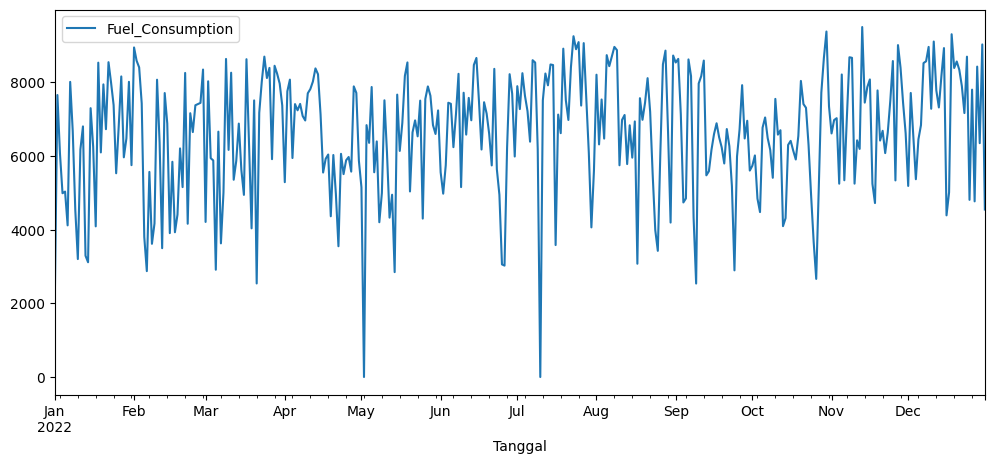

In [11]:
## melakukan visualisasi terhadap data
FC1.plot(figsize=(12,5))

Dari visualisasi di atas dapat diartikan bahwa terdapat nilai minimum 0 karena pada hari libur unit excavator tidak beroperasi. Nilai maksimum penggunaan bahan bakar pada unit excavator adalah 9506 liter. Selain itu, penggunaan bahan bakar pada unit excavator berkisar antara 3500 hingga 8000 liter per harinya

In [12]:
## melakukan uji ADF-Test
adf_test(FC1)

Results of Augmented Dickey-Fuller Test:
Test Statistic                -1.505984e+01
p-value                        9.037969e-28
#Lags Used                     0.000000e+00
Number of Observations Used    3.640000e+02
Critical Value (1%)           -3.448443e+00
Critical Value (5%)           -2.869513e+00
Critical Value (10%)          -2.571018e+00
dtype: float64


Berdasarkan hasil ADF Test di atas, nilai test statistic (-1.505984e+01) lebih kecil dari critical value pada tingkat signifikansi 1%, 5%, dan 10%, dan nilai p (9.037969e-28) lebih kecil dari tingkat signifikansi 0,05. Oleh karena itu, dapat disimpulkan bahwa data runtun waktu tersebut stasioner

# Data Modelling
pada tahap ini ada beberapa model yang akan diterapkan yaitu:
- ARIMA
- GRU
- AutoTS

In [13]:
## Function untuk melakukan sliding window
def sliding_window(data, window_size):
    sub_seq, next_values = [], []
    for i in range(len(data)-window_size):
        sub_seq.append(data[i:i+window_size])
        next_values.append(data[i+window_size])
    X = np.stack(sub_seq)
    y = np.array(next_values)
    return X,y

In [14]:
## function model GRU
def create_model(GRU_unit=64, dropout=0.2): 
    # create model
    model_GRU = Sequential()
    model_GRU.add(GRU(units=GRU_unit, input_shape=(window_size, 1)))
    model_GRU.add(Dense(32, activation='relu'))
    model_GRU.add(Dropout(dropout))
    model_GRU.add(Dense(1))

    # Compile model
    model_GRU.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model_GRU

## ARIMA (Autoregresiive Integrated Moving Average)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6437.925, Time=1.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7480.606, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6590.698, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7155.676, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6437.175, Time=0.75 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6967.193, Time=0.75 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6447.460, Time=0.97 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=6437.716, Time=1.03 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=6868.471, Time=1.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.78 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=6437.591, Time=1.51 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=6431.425, Time=0.30 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=6428.952, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6430.436, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : 

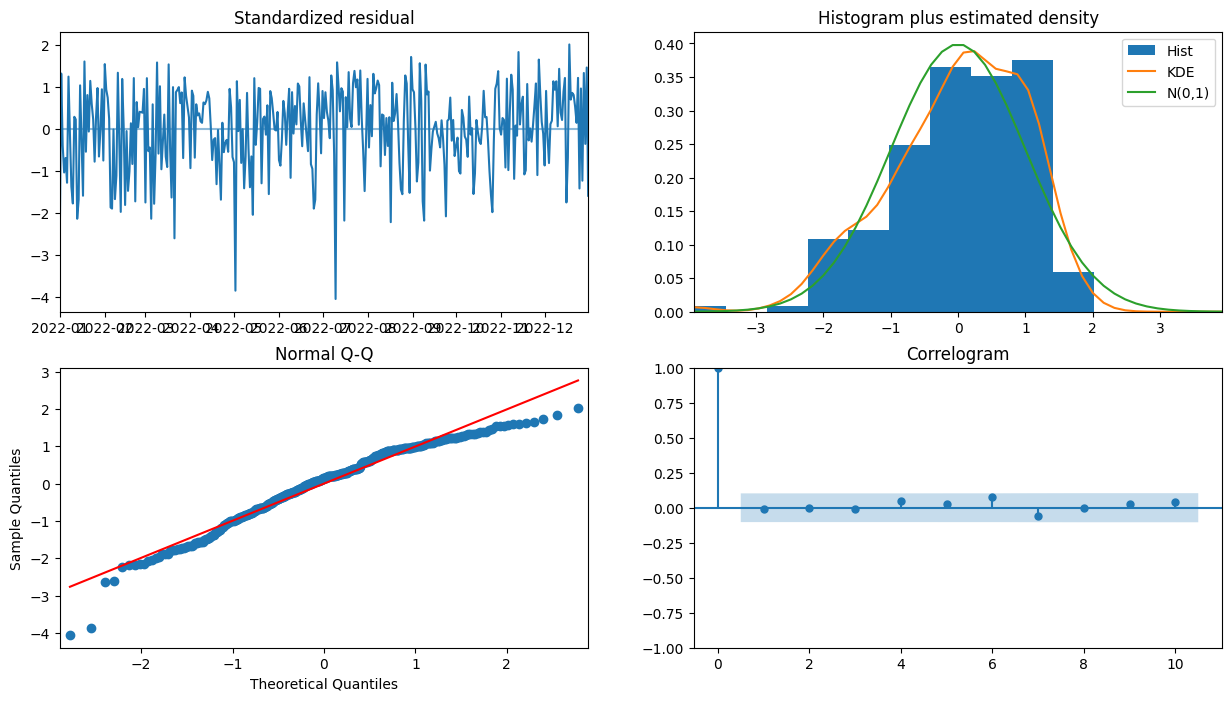

In [15]:
## mencari best parameter AR, I, dan MA menggunakan auto_arima 
autoar = auto_arima(FC1, test='adf', # use adftest to find optimal 'd'
                      seasonal=False,   # No Seasonality 
                      trace=True,
                      error_action='ignore',  information_criterion='aic', 
                      suppress_warnings=True, 
                      stepwise=True)
autoar.fit(FC1)
print(autoar.summary())
autoar.plot_diagnostics(figsize=(15,8))
plt.show()

In [16]:
## membangun model ARIMA sesuai dengan best parameter sebelumnya
model_ARIMA = sm.tsa.ARIMA(FC1, order=(0,0,2))
results_ARIMA=model_ARIMA.fit()

## melihat summary dari model ARIMA
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:       Fuel_Consumption   No. Observations:                  365
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -3210.484
Date:                Sat, 18 Feb 2023   AIC                           6428.967
Time:                        08:37:54   BIC                           6444.567
Sample:                    01-01-2022   HQIC                          6435.167
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6604.5781    125.027     52.825      0.000    6359.530    6849.627
ma.L1          0.2375      0.050      4.773      0.000       0.140       0.335
ma.L2          0.0966      0.051      1.894      0.0

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [17]:
predictions_ARIMA = pd.DataFrame(results_ARIMA.predict(), copy=True)

In [37]:
predictions_ARIMA_model = predictions_ARIMA.iloc[255:]

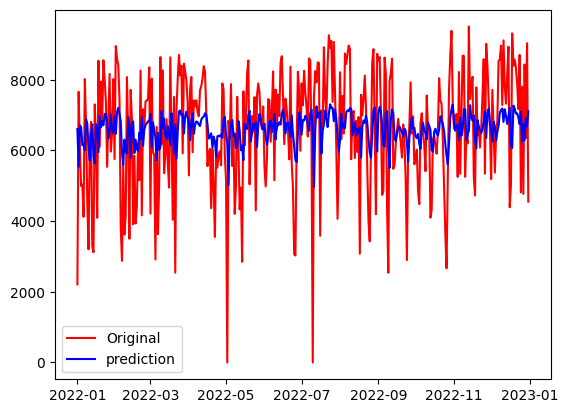

In [28]:
## plotting actual values
plt.plot(FC1, color='red', label='Original')

## plotting predictions
plt.plot(predictions_ARIMA, color='blue', label='prediction')
plt.legend()
plt.show()

Dari visualisasi di atas dapat dilihat bahwa model ARIMA tidak mampu mengikuti fluktuasi atau pergerakan penggunaan bahan bakar pada unit excavator

## GRU (Gated Recurrent Unit)

In [41]:
## melakukan pembagian data train dan data test dengan ratio 70:30
train_size_FC = int(len(FC2) * 0.70)
train_FC = FC2[:train_size_FC]
test_FC = FC2[train_size_FC:].reset_index(drop=True)

In [42]:
## melakukan standarisasi nilai
scaler_FC = MinMaxScaler()
scaler_FC.fit(train_FC[['Fuel_Consumption']])
train_FC['Scaled Fuel_Consumption'] = scaler_FC.transform(train_FC[['Fuel_Consumption']])
test_FC['Scaled Fuel_Consumption'] = scaler_FC.transform(test_FC[['Fuel_Consumption']])

In [43]:
window_size = 30

## melakukan sliding window 30 hari
X_train_FC, y_train_FC = sliding_window(train_FC[['Scaled Fuel_Consumption']].values, window_size)
X_test_FC, y_test_FC = sliding_window(test_FC[['Scaled Fuel_Consumption']].values, window_size)

In [44]:
## memerika dimensi masing-masing variabel
print(X_train_FC.shape, y_train_FC.shape)
print(X_test_FC.shape, y_test_FC.shape)

(225, 30, 1) (225, 1)
(80, 30, 1) (80, 1)


In [45]:
## membuat list parameter yang akan digunakan
GRU_unit = [16,32,64,128]
dropout = [0.1,0.2]

In [46]:
## Early Stopping
es = EarlyStopping(monitor = 'loss', mode = "min", patience = 5, verbose = 0)

## create model
model = KerasRegressor(build_fn=create_model, epochs=100, validation_split=0.1, batch_size=32, callbacks=[es], verbose=1,)

## define the grid search parameters
GRU_unit = [16,32,64,128]
dropout = [0.1,0.2]
param_grid = dict(GRU_unit=GRU_unit, dropout=dropout)

In [47]:
## mencari best parameter menggunakan GridSearchCV
grid_FC = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)

In [48]:
## mencari best parameter menggunakan GridSearchCV
grid_result_FC = grid_FC.fit(X_train_FC, y_train_FC)

Epoch 1/100
7/7 [==============================] - 8s 241ms/step - loss: 0.2109 - mae: 0.4064 - val_loss: 0.0553 - val_mae: 0.2136
Epoch 2/100
7/7 [==============================] - 0s 53ms/step - loss: 0.0626 - mae: 0.1920 - val_loss: 0.0582 - val_mae: 0.2113
Epoch 3/100
7/7 [==============================] - 0s 54ms/step - loss: 0.0575 - mae: 0.1877 - val_loss: 0.0706 - val_mae: 0.2400
Epoch 4/100
7/7 [==============================] - 0s 52ms/step - loss: 0.0532 - mae: 0.1832 - val_loss: 0.0560 - val_mae: 0.2157
Epoch 5/100
7/7 [==============================] - 0s 52ms/step - loss: 0.0484 - mae: 0.1764 - val_loss: 0.0561 - val_mae: 0.2130
Epoch 6/100
7/7 [==============================] - 0s 56ms/step - loss: 0.0464 - mae: 0.1686 - val_loss: 0.0585 - val_mae: 0.2206
Epoch 7/100
7/7 [==============================] - 0s 50ms/step - loss: 0.0463 - mae: 0.1695 - val_loss: 0.0564 - val_mae: 0.2166
Epoch 8/100
7/7 [==============================] - 0s 51ms/step - loss: 0.0418 - mae: 0.1

In [49]:
## menampilkan hasil best parameter
print("Best: %f using %s" % (grid_result_FC.best_score_, grid_result_FC.best_params_))
means_FC = grid_result_FC.cv_results_['mean_test_score']
stds_FC = grid_result_FC.cv_results_['std_test_score']
params_FC = grid_result_FC.cv_results_['params']
for mean, stdev, param in zip(means_FC, stds_FC, params_FC):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.034420 using {'GRU_unit': 128, 'dropout': 0.2}
-0.034539 (0.006207) with: {'GRU_unit': 16, 'dropout': 0.1}
-0.034776 (0.006824) with: {'GRU_unit': 16, 'dropout': 0.2}
-0.034510 (0.007417) with: {'GRU_unit': 32, 'dropout': 0.1}
-0.035467 (0.007804) with: {'GRU_unit': 32, 'dropout': 0.2}
-0.034584 (0.005677) with: {'GRU_unit': 64, 'dropout': 0.1}
-0.036152 (0.007289) with: {'GRU_unit': 64, 'dropout': 0.2}
-0.036250 (0.007406) with: {'GRU_unit': 128, 'dropout': 0.1}
-0.034420 (0.006588) with: {'GRU_unit': 128, 'dropout': 0.2}


In [50]:
## mengambil model terbaik
best_model_FC = grid_result_FC.best_estimator_.model

In [51]:
# Prediksi data train
predict_train_FC = scaler_FC.inverse_transform(best_model_FC.predict(X_train_FC))
true_train_FC = scaler_FC.inverse_transform(y_train_FC)

# Prediksi data test
predict_test_FC = scaler_FC.inverse_transform(best_model_FC.predict(X_test_FC))
true_test_FC = scaler_FC.inverse_transform(y_test_FC)

3/3 [==============================] - 0s 14ms/step


<AxesSubplot: xlabel='Tanggal', ylabel='Fuel_Consumption'>

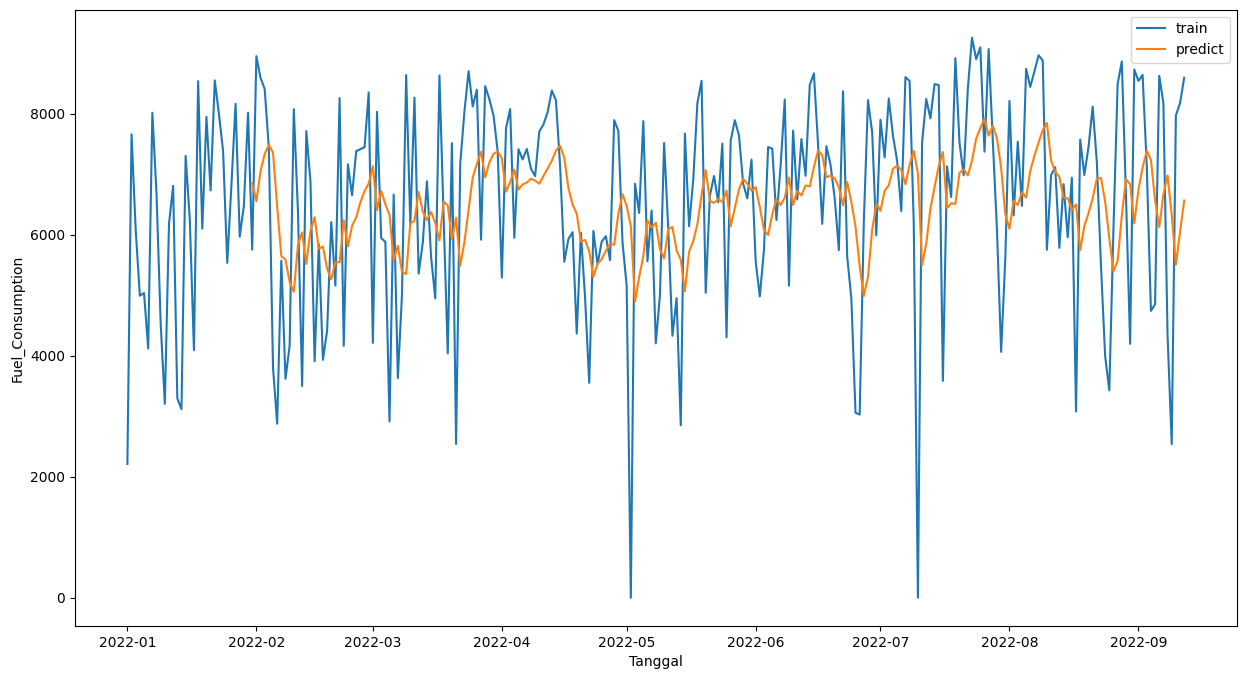

In [52]:
## membandingkan data model dengan data actual train
train_FC['predict'] = np.nan
train_FC['predict'][-len(predict_train_FC):] = predict_train_FC[:,0]

plt.figure(figsize=(15,8))
sns.lineplot(data=train_FC, x='Tanggal', y='Fuel_Consumption', label = 'train')
sns.lineplot(data=train_FC, x='Tanggal', y='predict', label = 'predict')

<AxesSubplot: xlabel='Tanggal', ylabel='Fuel_Consumption'>

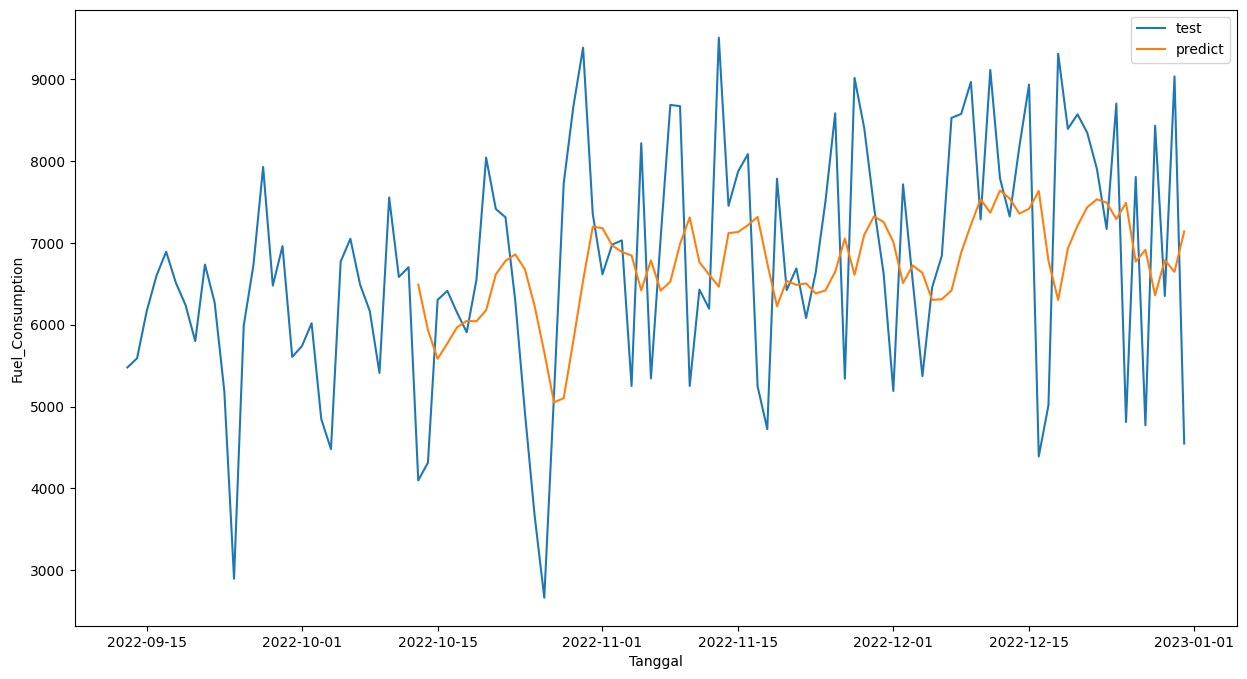

In [53]:
## membandingkan data model dengan data actual test
test_FC['predict'] = np.nan
test_FC['predict'][-len(predict_test_FC):] = predict_test_FC[:,0]

plt.figure(figsize=(15,8))
sns.lineplot(data=test_FC, x='Tanggal', y='Fuel_Consumption', label = 'test')
sns.lineplot(data=test_FC, x='Tanggal', y='predict', label = 'predict')

In [54]:
result_test = test_FC.iloc[30:]

## AutoTS

In [56]:
model = AutoTS(
    forecast_length=3,
    frequency='D',
    ensemble='simple',
    max_generations=5,
    num_validations=2,
)

In [57]:
FC2['series_id'] = 'GS10'

In [59]:
train_FC2 = FC2[:train_size_FC]
train_FC2

,Tanggal,Fuel_Consumption,series_id
0,2022-01-01,2212,GS10
1,2022-01-02,7659,GS10
2,2022-01-03,6075,GS10
3,2022-01-04,4992,GS10
4,2022-01-05,5036,GS10
...,...,...,...
250,2022-09-08,4337,GS10
251,2022-09-09,2539,GS10
252,2022-09-10,7972,GS10
253,2022-09-11,8175,GS10


In [60]:
model = model.fit(train_FC2,    
                  date_col='Tanggal',
                  value_col='Fuel_Consumption', id_col='series_id'
                  )

Model Number: 1 with model ARIMA in generation 0 of 5
Model Number: 2 with model AverageValueNaive in generation 0 of 5
Model Number: 3 with model AverageValueNaive in generation 0 of 5
Model Number: 4 with model AverageValueNaive in generation 0 of 5
Model Number: 5 with model DatepartRegression in generation 0 of 5
Model Number: 6 with model DatepartRegression in generation 0 of 5
Model Number: 7 with model DatepartRegression in generation 0 of 5
Model Number: 8 with model DatepartRegression in generation 0 of 5
Epoch 1/50
8/8 [==============================] - 19s 20ms/step - loss: 0.3918
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.3877
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.3836
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 0.3844
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.3818
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 0.3792
Epoch 7/50


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks   

Model Number: 39 with model MultivariateRegression in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 39: MultivariateRegression
Model Number: 40 with model DatepartRegression in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 40: DatepartRegression
Model Number: 41 with model SeasonalNaive in generation 0 of 5
Model Number: 42 with model DatepartRegression in generation 0 of 5
Model Number: 43 with model UnobservedComponents in generation 0 of 5
Model Number: 44 with model UnobservedComponents in generation 0 of 5
Model Number: 45 with model ETS in generation 0 of 5
Model Number: 46 with model VECM in generation 0 of 5
Template Eval Error: ValueError('Only gave one variable to VECM') in model 46: VECM
Model Number: 47 with model ARDL in generation 0 of 5
Model Number: 48 with model MultivariateMotif in generation 0 of 5
Model Number: 49 with model

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.0s


Model Number: 58 with model NVAR in generation 0 of 5


[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 59 with model Theta in generation 0 of 5
Model Number: 60 with model UnivariateRegression in generation 0 of 5
Template Eval Error: ValueError('Input X contains NaN.\nDecisionTreeRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values') in model 60: UnivariateRegression
Model Number: 61 with model ARCH in generation 0 of 5
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 61: ARCH
Model Numbe

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 112 with model MetricMotif in generation 0 of 5
Model Number: 113 with model AverageValueNaive in generation 0 of 5
Model Number: 114 with model ARDL in generation 0 of 5
Model Number: 115 with model ARDL in generation 0 of 5
Model Number: 116 with model SeasonalNaive in generation 0 of 5
Model Number: 117 with model SeasonalNaive in generation 0 of 5
Model Number: 118 with model ARDL in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 118: ARDL
Model Number: 119 with model ConstantNaive in generation 0 of 5
Model Number: 120 with model ARIMA in generation 0 of 5
Model Number: 121 with model ARCH in generation 0 of 5
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 121: ARCH
Model Number: 122 with model Theta in generation 0 of 5
Model Number: 123 with model UnivariateMotif in generation 0 of 5
Model Number: 124 with model UnivariateMotif in generation 0 of 5
Model 

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s


Model Number: 126 with model GLM in generation 0 of 5
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 126: GLM
Model Number: 127 with model LastValueNaive in generation 0 of 5


[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 128 with model SectionalMotif in generation 0 of 5
Model Number: 129 with model ConstantNaive in generation 0 of 5
Model Number: 130 with model UnivariateMotif in generation 0 of 5
Model Number: 131 with model SeasonalNaive in generation 0 of 5
Model Number: 132 with model VAR in generation 0 of 5
Template Eval Error: ValueError('Only gave one variable to VAR') in model 132: VAR
Model Number: 133 with model UnivariateMotif in generation 0 of 5
Model Number: 134 with model SeasonalNaive in generation 0 of 5
Model Number: 135 with model ARCH in generation 0 of 5
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 135: ARCH
Model Number: 136 with model LastValueNaive in generation 0 of 5
Model Number: 137 with model WindowRegression in generation 0 of 5
Model Number: 138 with model GLM in generation 0 of 5
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 138: GLM
Model Number:

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished


Model Number: 203 with model SectionalMotif in generation 1 of 5


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished


Model Number: 204 with model UnivariateMotif in generation 1 of 5
Model Number: 205 with model GLM in generation 1 of 5
Model Number: 206 with model SectionalMotif in generation 1 of 5
Model Number: 207 with model ConstantNaive in generation 1 of 5
Model Number: 208 with model NVAR in generation 1 of 5
Model Number: 209 with model UnivariateMotif in generation 1 of 5
Model Number: 210 with model Theta in generation 1 of 5
Model Number: 211 with model Theta in generation 1 of 5
Model Number: 212 with model SeasonalNaive in generation 1 of 5
Model Number: 213 with model ConstantNaive in generation 1 of 5
Model Number: 214 with model SeasonalNaive in generation 1 of 5
Model Number: 215 with model NVAR in generation 1 of 5
Model Number: 216 with model ARIMA in generation 1 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 216: ARIMA
Model Number: 217 with model MultivariateRegression in generation 1 of 5


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished


Model Number: 218 with model SectionalMotif in generation 1 of 5


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished


Model Number: 219 with model ARDL in generation 1 of 5
Model Number: 220 with model ETS in generation 1 of 5
ETS error ValueError('Can only dampen the trend component')
ETS failed on GS10 with ValueError('Can only dampen the trend component')
Model Number: 221 with model SectionalMotif in generation 1 of 5
Model Number: 222 with model SeasonalNaive in generation 1 of 5
Model Number: 223 with model ConstantNaive in generation 1 of 5
Model Number: 224 with model GLM in generation 1 of 5
Model Number: 225 with model ETS in generation 1 of 5
ETS error ValueError('Can only dampen the trend component')
ETS failed on GS10 with ValueError('Can only dampen the trend component')
Model Number: 226 with model SectionalMotif in generation 1 of 5
Model Number: 227 with model UnobservedComponents in generation 1 of 5
Template Eval Error: ValueError('Model UnobservedComponents returned NaN for one or more series. fail_on_forecast_nan=True') in model 227: UnobservedComponents
Model Number: 228 with mod

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished


Model Number: 274 with model UnobservedComponents in generation 1 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 274: UnobservedComponents
Model Number: 275 with model SeasonalNaive in generation 1 of 5


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished


Model Number: 276 with model AverageValueNaive in generation 1 of 5
Model Number: 277 with model MultivariateMotif in generation 1 of 5
Model Number: 278 with model Theta in generation 1 of 5
Model Number: 279 with model MetricMotif in generation 1 of 5
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 279: MetricMotif
Model Number: 280 with model Theta in generation 1 of 5
HolidayTransformer: no anomalies detected.
Template Eval Error: Exception('Transformer HolidayTransformer failed on fit') in model 280: Theta
Model Number: 281 with model SectionalMotif in generation 1 of 5
Model Number: 282 with model Theta in generation 1 of 5
Model Number: 283 with model AverageValueNaive in generation 1 of 5
Model Number: 284 with model UnobservedComponents in generation 1 of 5
Model Number: 285 with model MetricMotif in generation 1 of 5
Model Number: 286 with model ETS in generation 1 of 5
Model Number: 287 with model ARDL in generation 1 of 5
Model Number: 288 with mod

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done 444 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done 794 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed:    3.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    0.1s


Model Number: 292 with model SeasonalNaive in generation 1 of 5


[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:    0.2s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:    0.2s finished


Model Number: 293 with model LastValueNaive in generation 1 of 5
Model Number: 294 with model AverageValueNaive in generation 1 of 5
Model Number: 295 with model SectionalMotif in generation 1 of 5
Model Number: 296 with model SectionalMotif in generation 1 of 5
Model Number: 297 with model ARDL in generation 1 of 5
Model Number: 298 with model NVAR in generation 1 of 5
Model Number: 299 with model ETS in generation 1 of 5
ETS error ValueError('Can only dampen the trend component')
ETS failed on GS10 with ValueError('Can only dampen the trend component')
Model Number: 300 with model ARIMA in generation 1 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 300: ARIMA
Model Number: 301 with model MetricMotif in generation 1 of 5
Model Number: 302 with model WindowRegression in generation 1 of 5
Template Eval Error: ModuleNotFoundError("No module named 'lightgbm'") in model 302: WindowRegression
Model Number: 303 with model ARDL in gen

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished


Model Number: 337 with model AverageValueNaive in generation 2 of 5


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished


Model Number: 338 with model MultivariateMotif in generation 2 of 5
Model Number: 339 with model SectionalMotif in generation 2 of 5
Model Number: 340 with model ETS in generation 2 of 5
Model Number: 341 with model GLS in generation 2 of 5
Model Number: 342 with model Theta in generation 2 of 5
Model Number: 343 with model NVAR in generation 2 of 5
Model Number: 344 with model NVAR in generation 2 of 5
Model Number: 345 with model ETS in generation 2 of 5
Model Number: 346 with model SectionalMotif in generation 2 of 5
Model Number: 347 with model UnivariateMotif in generation 2 of 5
Model Number: 348 with model UnobservedComponents in generation 2 of 5
Model Number: 349 with model MultivariateMotif in generation 2 of 5
Model Number: 350 with model UnivariateMotif in generation 2 of 5
Model Number: 351 with model GLS in generation 2 of 5
Model Number: 352 with model ETS in generation 2 of 5
Model Number: 353 with model UnivariateMotif in generation 2 of 5
Template Eval Error: Exceptio

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks   

Model Number: 357 with model MultivariateRegression in generation 2 of 5


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished


Model Number: 358 with model ARDL in generation 2 of 5


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished


Model Number: 359 with model DatepartRegression in generation 2 of 5
Model Number: 360 with model SeasonalNaive in generation 2 of 5
Model Number: 361 with model DatepartRegression in generation 2 of 5
Model Number: 362 with model Theta in generation 2 of 5
Model Number: 363 with model ARDL in generation 2 of 5
Model Number: 364 with model WindowRegression in generation 2 of 5
Model Number: 365 with model UnivariateMotif in generation 2 of 5
Model Number: 366 with model MetricMotif in generation 2 of 5
Model Number: 367 with model DatepartRegression in generation 2 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 367: DatepartRegression
Model Number: 368 with model SeasonalNaive in generation 2 of 5
Model Number: 369 with model ConstantNaive in generation 2 of 5
Model Number: 370 with model ETS in generation 2 of 5
Model Number: 371 with model UnivariateMotif in generation 2 of 5
Model Number: 372 with model UnivariateMotif in gener

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished


Model Number: 444 with model ConstantNaive in generation 3 of 5


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished


Model Number: 445 with model GLM in generation 3 of 5
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 445: GLM
Model Number: 446 with model SectionalMotif in generation 3 of 5
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 446: SectionalMotif
Model Number: 447 with model SectionalMotif in generation 3 of 5
Model Number: 448 with model LastValueNaive in generation 3 of 5
Model Number: 449 with model MultivariateRegression in generation 3 of 5
Template Eval Error: ModuleNotFoundError("No module named 'xgboost'") in model 449: MultivariateRegression
Model Number: 450 with model ConstantNaive in generation 3 of 5
Model Number: 451 with model Theta in generation 3 of 5
Model Number: 452 with model SeasonalNaive in generation 3 of 5
Model Number: 453 with model ARDL in generation 3 of 5
Model Number: 454 with model MultivariateMotif in generation 3 of 5
Model Number: 455 with model ARDL in g

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks   

Model Number: 504 with model MultivariateRegression in generation 3 of 5


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished


Model Number: 505 with model GLS in generation 3 of 5


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished


Model Number: 506 with model Theta in generation 3 of 5
Model Number: 507 with model Theta in generation 3 of 5
Model Number: 508 with model ARDL in generation 3 of 5
Model Number: 509 with model MultivariateMotif in generation 3 of 5
Model Number: 510 with model SeasonalNaive in generation 3 of 5
Model Number: 511 with model UnivariateMotif in generation 3 of 5
Model Number: 512 with model GLS in generation 3 of 5
Model Number: 513 with model SectionalMotif in generation 3 of 5
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 513: SectionalMotif
Model Number: 514 with model SectionalMotif in generation 3 of 5
Model Number: 515 with model MetricMotif in generation 3 of 5
Model Number: 516 with model MultivariateRegression in generation 3 of 5


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s


Model Number: 517 with model NVAR in generation 3 of 5
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 517: NVAR
Model Number: 518 with model SectionalMotif in generation 3 of 5
Model Number: 519 with model ETS in generation 3 of 5


[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished


Model Number: 520 with model MultivariateMotif in generation 3 of 5
Model Number: 521 with model ConstantNaive in generation 3 of 5
Model Number: 522 with model SeasonalNaive in generation 3 of 5
Model Number: 523 with model DatepartRegression in generation 3 of 5
Model Number: 524 with model NVAR in generation 3 of 5
Model Number: 525 with model LastValueNaive in generation 3 of 5
Model Number: 526 with model Theta in generation 3 of 5
Model Number: 527 with model AverageValueNaive in generation 3 of 5
Model Number: 528 with model DatepartRegression in generation 3 of 5
Template Eval Error: InvalidParameterError("The 'base_estimator' parameter of AdaBoostRegressor must be an object implementing 'fit' and 'predict' or a str among {'deprecated'}. Got None instead.") in model 528: DatepartRegression
Model Number: 529 with model WindowRegression in generation 3 of 5
Model Number: 530 with model Theta in generation 3 of 5
Model Number: 531 with model MultivariateMotif in generation 3 of 5


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks   

Model Number: 599 with model WindowRegression in generation 4 of 5
Model Number: 600 with model LastValueNaive in generation 4 of 5
Model Number: 601 with model ConstantNaive in generation 4 of 5
Model Number: 602 with model ETS in generation 4 of 5
Model Number: 603 with model MultivariateRegression in generation 4 of 5
Model Number: 604 with model SectionalMotif in generation 4 of 5
Model Number: 605 with model ARDL in generation 4 of 5
Model Number: 606 with model UnobservedComponents in generation 4 of 5
Model Number: 607 with model Theta in generation 4 of 5
Model Number: 608 with model ARIMA in generation 4 of 5
Model Number: 609 with model UnivariateMotif in generation 4 of 5
Model Number: 610 with model SectionalMotif in generation 4 of 5
Model Number: 611 with model DatepartRegression in generation 4 of 5
Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 611: DatepartRegression
Model Number: 612 

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks   

Model Number: 630 with model Theta in generation 4 of 5
Model Number: 631 with model NVAR in generation 4 of 5
Model Number: 632 with model ETS in generation 4 of 5
Model Number: 633 with model Theta in generation 4 of 5
Model Number: 634 with model LastValueNaive in generation 4 of 5
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 634: LastValueNaive
Model Number: 635 with model GLS in generation 4 of 5
Model Number: 636 with model ConstantNaive in generation 4 of 5
Model Number: 637 with model UnobservedComponents in generation 4 of 5
Model Number: 638 with model NVAR in generation 4 of 5
Model Number: 639 with model MultivariateRegression in generation 4 of 5
Model Number: 640 with model ARDL in generation 4 of 5
Model Number: 641 with model UnivariateMotif in generation 4 of 5
Model Number: 642 with model SectionalMotif in generation 4 of 5
Model Number: 643 with model GLM in generation 4 of 5
Template Eval Error: Exception('Transformer BTCD faile

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s


Model Number: 686 with model AverageValueNaive in generation 4 of 5


[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished


New Generation: 5 of 5
Model Number: 687 with model SectionalMotif in generation 5 of 5
Model Number: 688 with model ARIMA in generation 5 of 5
Model Number: 689 with model WindowRegression in generation 5 of 5
Model Number: 690 with model MultivariateRegression in generation 5 of 5
Model Number: 691 with model MetricMotif in generation 5 of 5
Model Number: 692 with model UnobservedComponents in generation 5 of 5
Model Number: 693 with model LastValueNaive in generation 5 of 5
Model Number: 694 with model MetricMotif in generation 5 of 5
Model Number: 695 with model MultivariateRegression in generation 5 of 5


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s


Model Number: 696 with model ARDL in generation 5 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 696: ARDL
Model Number: 697 with model MultivariateMotif in generation 5 of 5
Model Number: 698 with model MultivariateMotif in generation 5 of 5


[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished


Model Number: 699 with model Theta in generation 5 of 5
Model Number: 700 with model GLM in generation 5 of 5
Model Number: 701 with model MultivariateMotif in generation 5 of 5
Model Number: 702 with model MultivariateRegression in generation 5 of 5
Model Number: 703 with model Theta in generation 5 of 5
Model Number: 704 with model MultivariateMotif in generation 5 of 5
Model Number: 705 with model ConstantNaive in generation 5 of 5
Model Number: 706 with model WindowRegression in generation 5 of 5
Template Eval Error: ModuleNotFoundError("No module named 'xgboost'") in model 706: WindowRegression
Model Number: 707 with model AverageValueNaive in generation 5 of 5
Model Number: 708 with model GLM in generation 5 of 5
Model Number: 709 with model UnivariateMotif in generation 5 of 5
Model Number: 710 with model NVAR in generation 5 of 5
Model Number: 711 with model UnivariateMotif in generation 5 of 5
Model Number: 712 with model GLS in generation 5 of 5
Model Number: 713 with model U

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks   

Model Number: 715 with model ARDL in generation 5 of 5
Model Number: 716 with model MultivariateMotif in generation 5 of 5
Model Number: 717 with model Theta in generation 5 of 5
Model Number: 718 with model UnivariateMotif in generation 5 of 5
Model Number: 719 with model SectionalMotif in generation 5 of 5
Model Number: 720 with model DatepartRegression in generation 5 of 5
HolidayTransformer: no anomalies detected.
Template Eval Error: Exception('Transformer HolidayTransformer failed on fit') in model 720: DatepartRegression
Model Number: 721 with model NVAR in generation 5 of 5
Model Number: 722 with model UnivariateMotif in generation 5 of 5
Model Number: 723 with model ETS in generation 5 of 5
Model Number: 724 with model UnivariateMotif in generation 5 of 5
Model Number: 725 with model ConstantNaive in generation 5 of 5
Model Number: 726 with model SeasonalNaive in generation 5 of 5
Model Number: 727 with model LastValueNaive in generation 5 of 5
Model Number: 728 with model NVA

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks   

Model Number: 793 with model Ensemble in generation 6 of Ensembles
Model Number: 794 with model Ensemble in generation 6 of Ensembles
Validation Round: 1
Model Number: 1 of 120 with model Ensemble for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks   

📈 1 - Ensemble with avg smape 46.39: 
Model Number: 2 of 120 with model Ensemble for Validation 1
📈 2 - Ensemble with avg smape 26.61: 
Model Number: 3 of 120 with model Ensemble for Validation 1
3 - Ensemble with avg smape 26.61: 
Model Number: 4 of 120 with model Ensemble for Validation 1
4 - Ensemble with avg smape 26.96: 
Model Number: 5 of 120 with model Ensemble for Validation 1
5 - Ensemble with avg smape 34.51: 
Model Number: 6 of 120 with model NVAR for Validation 1
6 - NVAR with avg smape 29.79: 
Model Number: 7 of 120 with model Ensemble for Validation 1
7 - Ensemble with avg smape 36.28: 
Model Number: 8 of 120 with model Theta for Validation 1
8 - Theta with avg smape 36.95: 
Model Number: 9 of 120 with model Theta for Validation 1
9 - Theta with avg smape 36.48: 
Model Number: 10 of 120 with model Theta for Validation 1
10 - Theta with avg smape 36.09: 
Model Number: 11 of 120 with model Theta for Validation 1
11 - Theta with avg smape 37.02: 
Model Number: 12 of 120 with

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks   

20 - MultivariateRegression with avg smape 56.29: 
Model Number: 21 of 120 with model SectionalMotif for Validation 1
21 - SectionalMotif with avg smape 100.22: 
Model Number: 22 of 120 with model SectionalMotif for Validation 1
22 - SectionalMotif with avg smape 31.75: 
Model Number: 23 of 120 with model SectionalMotif for Validation 1
23 - SectionalMotif with avg smape 79.85: 
Model Number: 24 of 120 with model SectionalMotif for Validation 1
24 - SectionalMotif with avg smape 79.85: 
Model Number: 25 of 120 with model UnivariateMotif for Validation 1
25 - UnivariateMotif with avg smape 56.14: 
Model Number: 26 of 120 with model MultivariateRegression for Validation 1
26 - MultivariateRegression with avg smape 35.72: 
Model Number: 27 of 120 with model NVAR for Validation 1
27 - NVAR with avg smape 54.26: 
Model Number: 28 of 120 with model NVAR for Validation 1
28 - NVAR with avg smape 54.26: 
Model Number: 29 of 120 with model NVAR for Validation 1
29 - NVAR with avg smape 54.26: 


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks   

69 - MultivariateRegression with avg smape 70.36: 
Model Number: 70 of 120 with model DatepartRegression for Validation 1
70 - DatepartRegression with avg smape 49.24: 
Model Number: 71 of 120 with model MultivariateRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks   

71 - MultivariateRegression with avg smape 51.87: 
Model Number: 72 of 120 with model ARDL for Validation 1
72 - ARDL with avg smape 53.49: 
Model Number: 73 of 120 with model UnobservedComponents for Validation 1
73 - UnobservedComponents with avg smape 51.71: 
Model Number: 74 of 120 with model ARDL for Validation 1
74 - ARDL with avg smape 52.45: 
Model Number: 75 of 120 with model UnobservedComponents for Validation 1
75 - UnobservedComponents with avg smape 51.57: 
Model Number: 76 of 120 with model ARDL for Validation 1
76 - ARDL with avg smape 52.51: 
Model Number: 77 of 120 with model UnobservedComponents for Validation 1
77 - UnobservedComponents with avg smape 51.57: 
Model Number: 78 of 120 with model MetricMotif for Validation 1
78 - MetricMotif with avg smape 51.27: 
Model Number: 79 of 120 with model AverageValueNaive for Validation 1
79 - AverageValueNaive with avg smape 51.12: 
Model Number: 80 of 120 with model GLS for Validation 1
80 - GLS with avg smape 51.49: 
Model

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks   

📈 1 - Ensemble with avg smape 22.07: 
Model Number: 2 of 120 with model Ensemble for Validation 2
📈 2 - Ensemble with avg smape 12.92: 
Model Number: 3 of 120 with model Ensemble for Validation 2
3 - Ensemble with avg smape 12.92: 
Model Number: 4 of 120 with model Ensemble for Validation 2
4 - Ensemble with avg smape 13.16: 
Model Number: 5 of 120 with model Ensemble for Validation 2
5 - Ensemble with avg smape 18.15: 
Model Number: 6 of 120 with model NVAR for Validation 2
📈 6 - NVAR with avg smape 12.02: 
Model Number: 7 of 120 with model Ensemble for Validation 2
7 - Ensemble with avg smape 21.79: 
Model Number: 8 of 120 with model Theta for Validation 2
8 - Theta with avg smape 21.81: 
Model Number: 9 of 120 with model Theta for Validation 2
9 - Theta with avg smape 22.14: 
Model Number: 10 of 120 with model Theta for Validation 2
10 - Theta with avg smape 22.03: 
Model Number: 11 of 120 with model Theta for Validation 2
11 - Theta with avg smape 22.11: 
Model Number: 12 of 120 wi

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks   

20 - MultivariateRegression with avg smape 40.71: 
Model Number: 21 of 120 with model SectionalMotif for Validation 2
21 - SectionalMotif with avg smape 28.77: 
Model Number: 22 of 120 with model SectionalMotif for Validation 2
22 - SectionalMotif with avg smape 23.16: 
Model Number: 23 of 120 with model SectionalMotif for Validation 2
23 - SectionalMotif with avg smape 32.43: 
Model Number: 24 of 120 with model SectionalMotif for Validation 2
24 - SectionalMotif with avg smape 32.43: 
Model Number: 25 of 120 with model UnivariateMotif for Validation 2
25 - UnivariateMotif with avg smape 30.77: 
Model Number: 26 of 120 with model MultivariateRegression for Validation 2
26 - MultivariateRegression with avg smape 14.03: 
Model Number: 27 of 120 with model NVAR for Validation 2
27 - NVAR with avg smape 30.74: 
Model Number: 28 of 120 with model NVAR for Validation 2
28 - NVAR with avg smape 30.74: 
Model Number: 29 of 120 with model NVAR for Validation 2
29 - NVAR with avg smape 30.73: 
M

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks   

69 - MultivariateRegression with avg smape 33.62: 
Model Number: 70 of 120 with model DatepartRegression for Validation 2
70 - DatepartRegression with avg smape 36.91: 
Model Number: 71 of 120 with model MultivariateRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks   

71 - MultivariateRegression with avg smape 29.35: 
Model Number: 72 of 120 with model ARDL for Validation 2
72 - ARDL with avg smape 31.53: 
Model Number: 73 of 120 with model UnobservedComponents for Validation 2
73 - UnobservedComponents with avg smape 31.62: 
Model Number: 74 of 120 with model ARDL for Validation 2
74 - ARDL with avg smape 31.39: 
Model Number: 75 of 120 with model UnobservedComponents for Validation 2
75 - UnobservedComponents with avg smape 31.33: 
Model Number: 76 of 120 with model ARDL for Validation 2
76 - ARDL with avg smape 31.59: 
Model Number: 77 of 120 with model UnobservedComponents for Validation 2
77 - UnobservedComponents with avg smape 31.33: 
Model Number: 78 of 120 with model MetricMotif for Validation 2
78 - MetricMotif with avg smape 33.68: 
Model Number: 79 of 120 with model AverageValueNaive for Validation 2
79 - AverageValueNaive with avg smape 30.86: 
Model Number: 80 of 120 with model GLS for Validation 2
80 - GLS with avg smape 31.33: 
Model

In [61]:
print(model.best_model_name)
print('---------------------------')
print(model.best_model_params)
print('---------------------------')
print(model.best_model_transformation_params)
print('---------------------------')
print(model.metric_weighting)

Ensemble
---------------------------
{'model_name': 'BestN', 'model_count': 3, 'model_metric': 'mixed_metric', 'models': {'c1e6516d0ab89a35ce9bcb15a39381a9': {'Model': 'Ensemble', 'ModelParameters': '{"model_name": "BestN", "model_count": 3, "model_metric": "best_score_unique", "models": {"b93798c438ada75b2ecf96d1768113b1": {"Model": "Theta", "ModelParameters": "{\\"deseasonalize\\": true, \\"difference\\": false, \\"use_test\\": true, \\"method\\": \\"auto\\", \\"period\\": null, \\"theta\\": 2.5, \\"use_mle\\": false}", "TransformationParameters": "{\\"fillna\\": \\"rolling_mean_24\\", \\"transformations\\": {\\"0\\": \\"SeasonalDifference\\", \\"1\\": \\"RollingMeanTransformer\\", \\"2\\": \\"ClipOutliers\\"}, \\"transformation_params\\": {\\"0\\": {\\"lag_1\\": 7, \\"method\\": \\"Median\\"}, \\"1\\": {\\"fixed\\": false, \\"window\\": 10}, \\"2\\": {\\"method\\": \\"clip\\", \\"std_threshold\\": 2, \\"fillna\\": null}}}"}, "30a958c3b76ab29e4ef50e9d1cc0dca5": {"Model": "NVAR", "Mod

In [66]:
print(model)

Initiated AutoTS object with best model: 
Ensemble
{}
{'model_name': 'BestN', 'model_count': 3, 'model_metric': 'mixed_metric', 'models': {'c1e6516d0ab89a35ce9bcb15a39381a9': {'Model': 'Ensemble', 'ModelParameters': '{"model_name": "BestN", "model_count": 3, "model_metric": "best_score_unique", "models": {"b93798c438ada75b2ecf96d1768113b1": {"Model": "Theta", "ModelParameters": "{\\"deseasonalize\\": true, \\"difference\\": false, \\"use_test\\": true, \\"method\\": \\"auto\\", \\"period\\": null, \\"theta\\": 2.5, \\"use_mle\\": false}", "TransformationParameters": "{\\"fillna\\": \\"rolling_mean_24\\", \\"transformations\\": {\\"0\\": \\"SeasonalDifference\\", \\"1\\": \\"RollingMeanTransformer\\", \\"2\\": \\"ClipOutliers\\"}, \\"transformation_params\\": {\\"0\\": {\\"lag_1\\": 7, \\"method\\": \\"Median\\"}, \\"1\\": {\\"fixed\\": false, \\"window\\": 10}, \\"2\\": {\\"method\\": \\"clip\\", \\"std_threshold\\": 2, \\"fillna\\": null}}}"}, "30a958c3b76ab29e4ef50e9d1cc0dca5": {"Mod

In [62]:
## melatih model dan mencari model yang terbaik
prediction = model.predict(forecast_length=110)

In [63]:
forecasts_df = prediction.forecast

In [64]:
forecasts_df

,GS10
2022-09-13,8222.434591
2022-09-14,5488.841981
2022-09-15,4839.366440
2022-09-16,6990.170205
2022-09-17,7577.016185
...,...
2022-12-27,5096.649028
2022-12-28,3557.829240
2022-12-29,9154.878631
2022-12-30,8057.946207


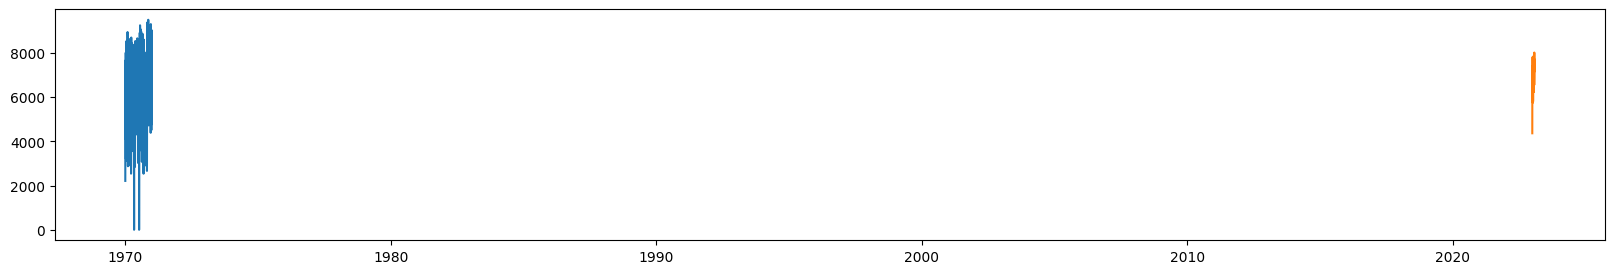

In [86]:
fig,ax = plt.subplots(figsize=(20,3))
ax.plot(FC2['Fuel_Consumption'])
ax.plot(prediction.forecast)

# Evaluasi

## ARIMA

In [40]:
print('Evaluasi Arima')
rmse =sqrt(mean_squared_error(test_FC['Fuel_Consumption'], predictions_ARIMA_model))
print('RMSE:' +str(rmse))
mse = mean_squared_error(test_FC['Fuel_Consumption'], predictions_ARIMA_model)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_FC['Fuel_Consumption'], predictions_ARIMA_model)
print('MAE: '+str(mae))

Evaluasi Arima
RMSE:1389.0015590877058
MSE: 1929325.3311480777
MAE: 1100.3706684094636


## GRU

In [55]:
print('Evaluasi GRU')
rmse1 =sqrt(mean_squared_error(result_test['Fuel_Consumption'], result_test['predict']))
print('RMSE:' +str(rmse1))
mse1 = mean_squared_error(result_test['Fuel_Consumption'], result_test['predict'])
print('MSE: '+str(mse1))
mae1 = mean_absolute_error(result_test['Fuel_Consumption'], result_test['predict'])
print('MAE: '+str(mae1))

Evaluasi GRU
RMSE:1568.6827461235619
MSE: 2460765.557985759
MAE: 1276.2755615234375


## AutoTS (Ensemble)

In [65]:
print('Evaluasi AutoTS (Ensemble)')
rmse1 =sqrt(mean_squared_error(test_FC['Fuel_Consumption'], forecasts_df))
print('RMSE:' +str(rmse1))
mse1 = mean_squared_error(test_FC['Fuel_Consumption'], forecasts_df)
print('MSE: '+str(mse1))
mae1 = mean_absolute_error(test_FC['Fuel_Consumption'], forecasts_df)
print('MAE: '+str(mae1))

Evaluasi AutoTS (Ensemble)
RMSE:2388.0264074260904
MSE: 5702670.12256436
MAE: 1865.5810911367466
